In [1]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from datetime import datetime
from chinese_calendar import is_workday, is_holiday


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

rz_df = pd.read_csv('复赛/trainb/网约房平台入住人表.csv')
dd_df = pd.read_csv('复赛/trainb/网约平台旅客订单信息.csv')
ms_df = pd.read_csv('初赛/traina/网约房注册民宿.csv')
dd_df_a = pd.read_csv('初赛/traina/网约平台旅客订单信息.csv')
rz_df_a = pd.read_csv('初赛/traina/网约房平台入住人表.csv')
submit = pd.read_csv('复赛/testb/submit_example_2.csv')

print('入住数据量',rz_df.shape)
print('订单数据量',dd_df.shape)
print('民宿数据量',ms_df.shape)
print('a订单数据量',dd_df_a.shape)
print('a入住数据量',rz_df_a.shape)
print('submit数据量',submit.shape)


入住数据量 (3344, 6)
订单数据量 (3333, 11)
民宿数据量 (5307, 20)
a订单数据量 (40550, 11)
a入住数据量 (40686, 6)
submit数据量 (3311, 3)


In [ ]:
# combine or not?
# rz_df = pd.concat([rz_df_a,rz_df]).reset_index(drop=True)
# dd_df = pd.concat([dd_df_a,dd_df]).reset_index(drop=True)

In [3]:
for guid in tqdm(rz_df.ORDER_PRIMARY_ID):
   if dd_df[dd_df.ORDER_PRIMARY_ID == guid].shape[0] > 1:
        print(guid)
        break
        #先确认是否所有订单最终只会得到一种状态
    # dd_df[dd_df.ORDER_PRIMARY_ID == guid]

100%|██████████| 3344/3344 [00:01<00:00, 2047.70it/s]


In [6]:
unique_ID = submit.HOTELID.unique()

In [20]:
min_date = dd_df.PRE_IN_TIME.min()#202107110000#302108312313
max_date = dd_df.PRE_OUT_TIME.max()#202109210000#102108312313

In [16]:
all_id = pd.Series(np.tile(unique_ID,pd.date_range(str(min_date)[:8],str(max_date)[:8]).shape[0]))
all_date = pd.Series(pd.date_range(str(min_date)[:8],str(max_date)[:8]).repeat(len(unique_ID)))
train_df = pd.DataFrame({'all_id':all_id,'all_date':all_date})
train_df['dayofweek'] = train_df.all_date.apply(lambda x: x.dayofweek + 1)#train_df.all_date.dayofweek
train_df['num_in'] = 0

In [17]:
for guid in tqdm(rz_df.ORDER_PRIMARY_ID):
    small_df = dd_df[dd_df.ORDER_PRIMARY_ID == guid]
    # print(small_df)
    if small_df.shape[0] == 1 and small_df.STATUS.values[0] != 0:
        in_time = small_df.PRE_IN_TIME.values[0]
        out_time = small_df.PRE_OUT_TIME.values[0]
        if in_time >= min_date and out_time <= max_date and in_time < out_time:
            for cur_date in pd.date_range(str(in_time)[:8],str(out_time)[:8])[:-1]:
                train_df.loc[(train_df.all_id == small_df.HOTELID.values[0]) & (train_df.all_date == cur_date) ,'num_in'] += 1
    # else:
    #     print(f'error date from {in_time} to {out_time}')
train_df['is_empty'] = train_df['num_in'].apply(lambda x: 1 if x == 0 else 0)


100%|██████████| 3344/3344 [00:19<00:00, 173.59it/s]


In [18]:
date_df = train_df.set_index('all_date')

<AxesSubplot:xlabel='all_date'>

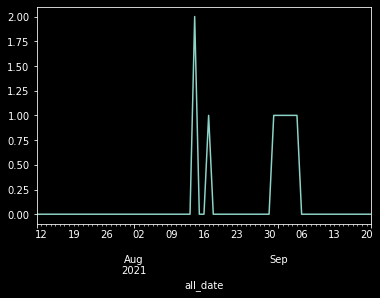

In [19]:
# randomly plot one id to validate
date_df[date_df.all_id == '324931'].num_in.plot()


In [25]:
date_df.num_in.value_counts()

0     32697
1      1067
2       686
3        58
4        14
5         2
10        2
6         2
9         1
Name: num_in, dtype: int64